In [74]:
import jax
import pandas as pd
import seaborn as sns
import jax.numpy as jnp
import flax.linen as nn
import matplotlib.pyplot as plt
from rebayes_mini.methods import low_rank_filter as lofi
from rebayes_mini.methods import low_rank_filter_revised as lofir

In [75]:
sns.set_palette("colorblind")

In [2]:
from functools import partial

In [3]:
%config InlineBackend.figure_format = "retina"

In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load data
Source: https://github.com/yaringal/DropoutUncertaintyExps/tree/master/UCI_Datasets/energy/data

In [6]:
url = "https://raw.githubusercontent.com/yaringal/DropoutUncertaintyExps/refs/heads/master/UCI_Datasets/energy/data/data.txt"
data = pd.read_csv(url, sep="\t", header=None)

data = data.sample(frac=1.0, axis=0, replace=False, random_state=314)

warmup = data.iloc[:50]
data = data.iloc[50:]

n_test = 200
test = data.iloc[-n_test:]
train = data.iloc[:-n_test]

In [7]:
tix = 8
y = train[tix]
X = train.drop(tix, axis=1).values

# Xmean = X.mean(axis=0, keepdims=True)
# Xstd = X.std(axis=0, keepdims=True)
# ymean = y.mean(axis=0)
# ystd = y.std(axis=0)

ymean = warmup.mean(axis=0)[tix]
ystd = warmup.std(axis=0)[tix]

Xmean = warmup.mean(axis=0).drop(tix).values
Xstd = warmup.std(axis=0).drop(tix).values

X = (X - Xmean) / Xstd
y = (y - ymean) / ystd

y = jnp.array(y)
X = jnp.array(X)

X_test = (test.drop(tix, axis=1).values - Xmean) / Xstd
y_test = (test[tix].values - ymean) / ystd

## Define model

In [8]:
class MLP(nn.Module):
    n_out: int
    
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(50)(x)
        x = nn.elu(x)
        x = nn.Dense(self.n_out)(x)
        return x


In [42]:
def callback(bel_update, bel_pred, y, x, agent):
    ypred = agent.link_fn(bel_update.mean, X_test).ravel()
    ypred = ypred * ystd + ymean
    ytest = y_test * ystd + ymean
    return jnp.sqrt(jnp.power(ytest - ypred, 2).mean())

In [52]:
key = jax.random.PRNGKey(314159)
model = MLP(n_out=1)
params_init = model.init(key, X)

In [84]:
ranks = [0, 5, 10, 20]
results = {}
for rank in ranks:
    print(rank, end="\r")
    # agent = lofi.GaussianFilter(model.apply, dynamics_covariance=1e-7, rank=rank, inflate_diag=False)
    # bel_init = agent.init_bel(params_init, cov=1e-4)
    agent = lofir.GaussianFilter(model.apply, dynamics_covariance=1e-7, rank=rank)
    bel_init = agent.init_bel(params_init, cov=1e-4)
    cfn = partial(callback, agent=agent)
    bel_final, hist = agent.scan(bel_init, y, X, callback_fn=cfn)
    results[rank] = hist

results = pd.DataFrame(results)
results.tail()

20

,0,5,10,20
513,6.661273,5.390716,5.216037,4.571359
514,6.647223,5.373575,5.195256,4.558000
515,6.641387,5.367894,5.189417,4.553705
516,6.633589,5.361300,5.184527,4.547174
517,6.619397,5.345706,5.173751,4.537258


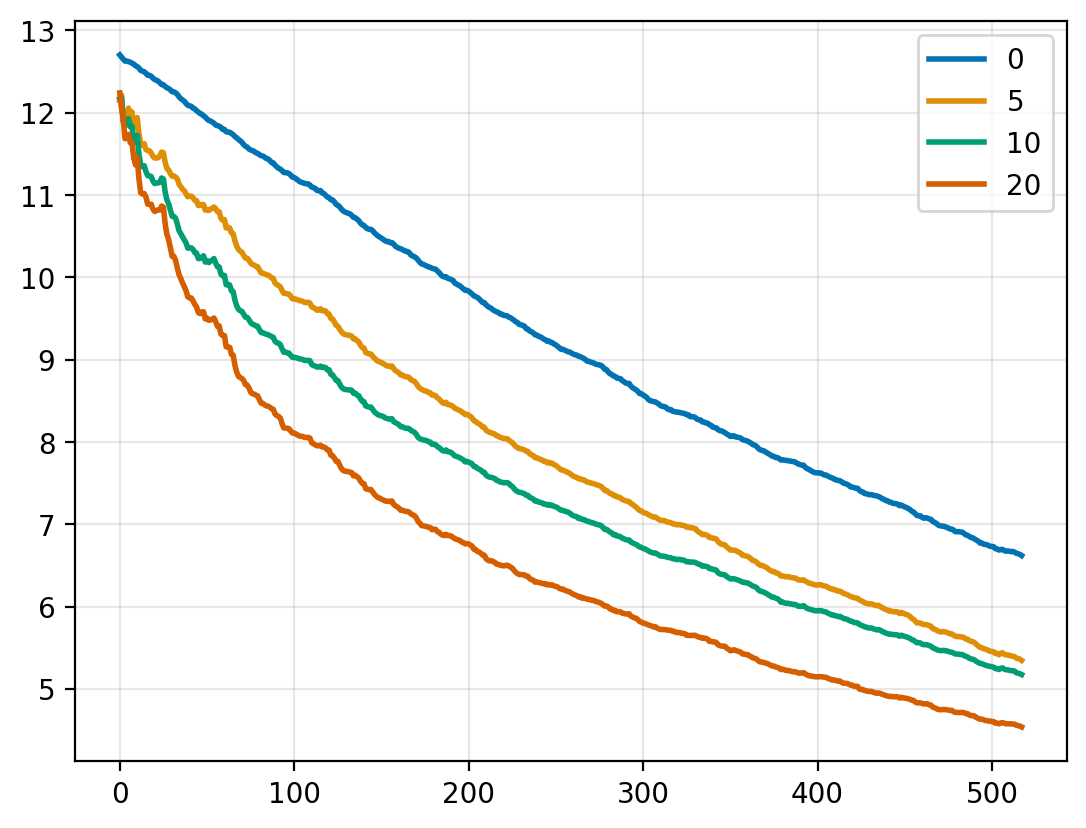

In [85]:
results.plot(linewidth=2)
plt.grid(alpha=0.3)